In [179]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
# Load the CSV file into a pandas DataFrame
from datetime import datetime

import numpy as np

# Set the aesthetics for the seaborn plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
plt.rcParams.update({"xtick.labelsize": 17, "ytick.labelsize": 17,
"axes.titlesize": 18, "axes.titleweight": 'bold', "axes.labelsize": 19, "axes.labelweight": 'bold'})
pd.set_option('display.max_columns', 50)


In [186]:
df = pd.read_csv("../results/all_results.csv")
# Find unique pairs in the dataframe


In [187]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
unique_pairs = df[['model_name', 'dataset_name']].drop_duplicates().dropna()

n_rows = len(unique_pairs)
n_rows

4

In [183]:
def create_pivot_table(df, model_name, dataset_name, regularization, metric='test_loss'):
    # Filter the DataFrame based on the input parameters
    filtered_df = df[(df['model_name'] == model_name) & 
                     (df['dataset_name'] == dataset_name) & 
                     (df['regularization'] == regularization)]

    # List of bit widths to consider
    bit_widths = [32, 16, 8, 4, 2]

    # Create a new DataFrame for the pivot table
    pivot_data = []

    for bit in bit_widths:
        if bit == 32:
            # For bit width 32, use the 'test_loss' column
            col_name = metric
        else:
            # For other bit widths, use the 'bit_{i}_{metric}' format
            col_name = f'bit_{bit}_{metric}'

        # Check if the column exists in the DataFrame
        if col_name in filtered_df.columns:
            # Extract the required values and add to the pivot data
            for index, row in filtered_df.iterrows():
                pivot_data.append({'Bit Width': f'bit_{bit}', 
                                   'Regularization Param': row['regularization_param'], 
                                   metric: row[col_name]})

    # Convert the list of data into a DataFrame
    pivot_df = pd.DataFrame(pivot_data)

    # Sort the DataFrame by 'Bit Width' in descending order
    pivot_df['Bit Width'] = pd.Categorical(pivot_df['Bit Width'], 
                                           categories=[f'bit_{b}' for b in bit_widths], 
                                           ordered=True)
    pivot_df = pivot_df.sort_values('Bit Width', ascending=False)

    # Create the pivot table
    pivot_table = pivot_df.pivot(index='Bit Width', columns='Regularization Param', values=metric)

    return pivot_table

In [184]:

def plot_heatmap(ax, pivot_table, regularization, metric, set_ylabel, model_name='', dataset_name=''):
    cbar_kws = {"orientation": "vertical", 
                "shrink": 1,
                'extend': 'min', 
                'extendfrac': 0.1, 
                "drawedges": True}
    sns.heatmap(pivot_table, annot=True, vmin=0, vmax=100, fmt=".2g", annot_kws={'size': 13}, 
                linewidths=1, cmap="inferno", cbar_kws=cbar_kws, ax=ax)
    if set_ylabel:
        ax.set_ylabel(f"{model_name}\n{dataset_name}", rotation=90, labelpad=15, fontsize=20)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('')

In [203]:
tmp = df[((df.dataset_name == 'FashionMNIST')) & (df.regularization.isin(['l1','l2','none']))] 

In [204]:
tmp.groupby(['regularization', 'lr']).size()

regularization  lr   
l1              0.001    11
l2              0.001    10
none            0.001     1
dtype: int64

In [205]:
def my_eval(x):
    try:
        return eval(x)
    except:
        print(x)
        return x

tmp[FIELD] = tmp[FIELD].apply(my_eval)

/tmp/ipykernel_805702/1973232397.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[FIELD] = tmp[FIELD].apply(my_eval)


/tmp/ipykernel_805702/1668231157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values(by='regularization_param', inplace=True)


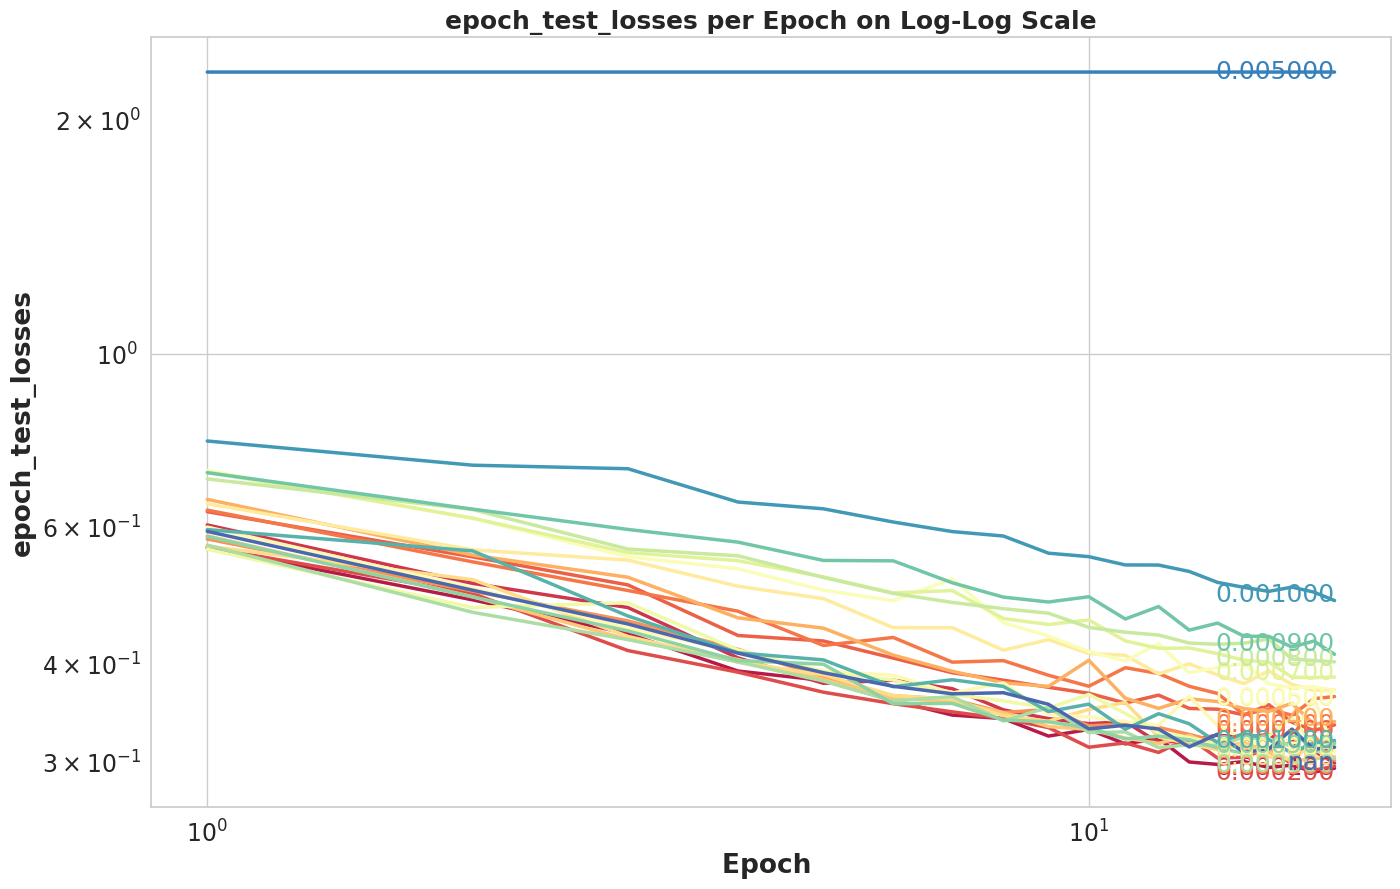

In [206]:
tmp.sort_values(by='regularization_param', inplace=True)
# Convert the 'epoch_test_losses' column to lists if they are stored as strings
FIELD = 'epoch_test_losses'
import ast
LIMIT = -1




# Generate a colormap based on the sorted DataFrame
colors = sns.color_palette("Spectral", len(tmp))

# Set up the plot with a specified figure size
plt.figure(figsize=(16, 10))

# Plotting each row with a color based on its sorted position and adding text labels
for (index, row), color in zip(tmp.iterrows(), colors):
    plt.loglog(range(1, len(row[FIELD][:LIMIT]) + 1), row[FIELD][:LIMIT],
           label='{:f}'.format(row['regularization_param']), color=color, base=10)
    # Add text annotation to the plot
    plt.text(len(row[FIELD][:LIMIT])+0, row[FIELD][LIMIT], 
             '{:f}'.format(row['regularization_param']), va='center', ha='right', color=color)

# Add xlabel, ylabel, and title to the plot
plt.xlabel('Epoch ')
plt.ylabel(FIELD)
plt.title(f'{FIELD} per Epoch on Log-Log Scale')

# Creating a sorted custom legend
handles, labels = plt.gca().get_legend_handles_labels()
# Convert labels to float and sort them alongside handles

# Display the plot
plt.show()

4 2
Error creating heatmap for resnet20, CIFAR-10, l1: 'Bit Width'
Error creating heatmap for resnet20, CIFAR-10, l2: 'Bit Width'
Error creating heatmap for resnet18, CIFAR-10, l1: 'Bit Width'
Error creating heatmap for resnet18, CIFAR-10, l2: 'Bit Width'
Error creating heatmap for lenet, MNIST, l1: 'Bit Width'
Error creating heatmap for lenet, MNIST, l2: 'Bit Width'


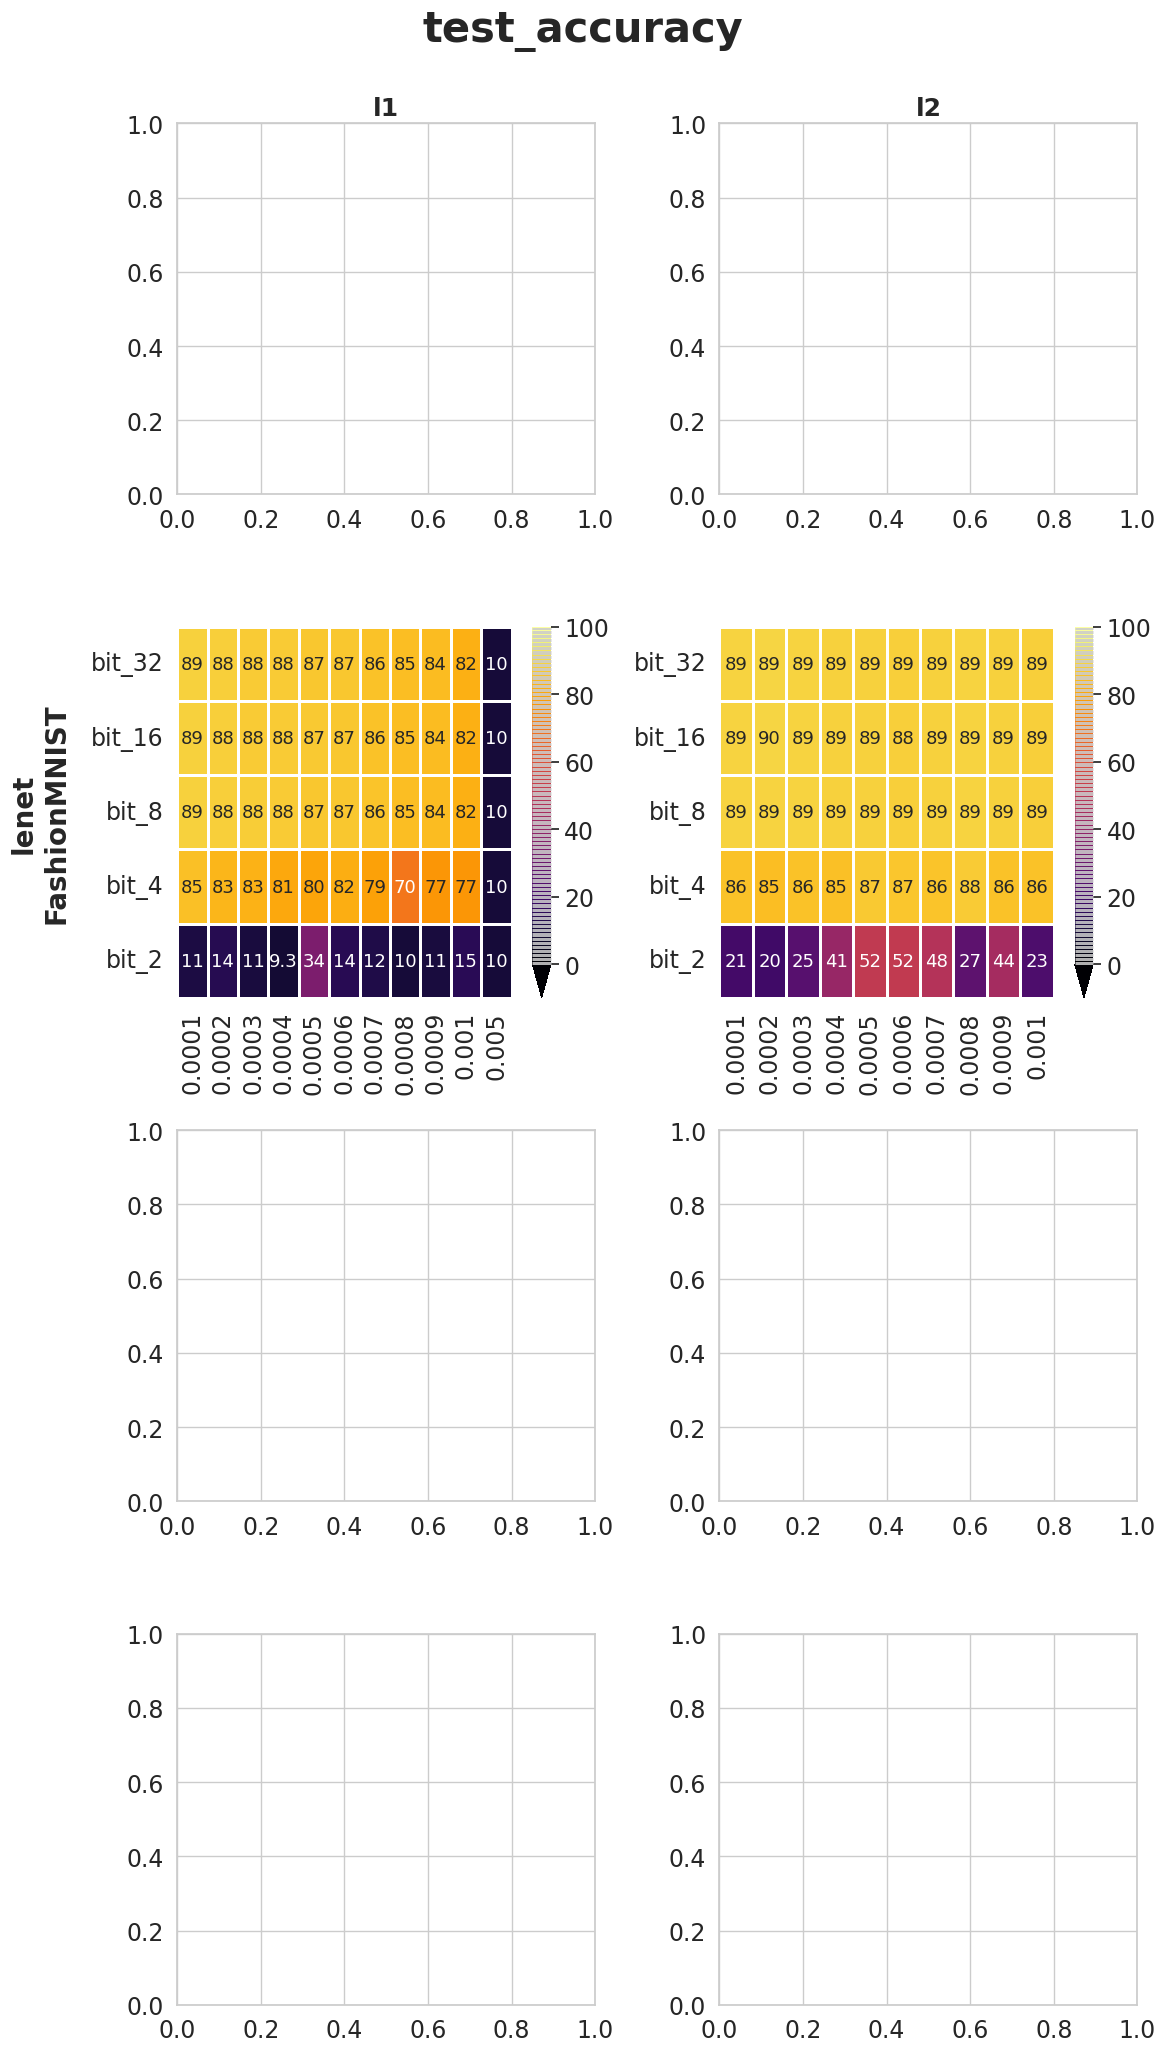

In [207]:
# List of model and dataset pairs
model_dataset_pairs = [
    ('lenet', 'FashionMNIST'),
    ('lenet', 'MNIST'),
    ('resnet18', 'CIFAR-10'),
    ('resnet20', 'CIFAR-10')
]

# Regularizations
regularizations = ["l1", "l2"]

# Metric to be used
metric = 'test_accuracy'

# Find unique pairs in the dataframe
unique_pairs = df[['model_name', 'dataset_name']].drop_duplicates().dropna()

n_rows = len(unique_pairs)
n_cols = len(regularizations)
print(n_rows, n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))


for i, (model_name, dataset_name) in enumerate(unique_pairs.values):
    for j, regularization in enumerate(regularizations):
        ax = axes[i, j]

        # Set titles for the first row and handle y-axis labels
        if i == 0:
            ax.set_title(regularization)
        set_ylabel = (j == 0)  # Set y-axis label only for the first plot in each row

        # Compute and plot the heatmap
        try:
            pivot_table = create_pivot_table(tmp, model_name, dataset_name, regularization, metric)
            plot_heatmap(ax, pivot_table, regularization, metric, set_ylabel, model_name, dataset_name)
        except Exception as e:
            print(f"Error creating heatmap for {model_name}, {dataset_name}, {regularization}: {e}")

plt.tight_layout()
fig.suptitle(metric, fontsize=30, weight='bold', y=1.03)
plt.savefig(f"results_{metric}.pdf", dpi=800)

plt.show()


In [161]:
df[
    (df["model_name"] == "resnet20") &
    (df["dataset_name"] == "CIFAR-10") &
    (df["regularization"] == "none")
][['model_name', 'total_weights', 'seed', 'dataset_name', 
                      'regularization', 'regularization_param', 'num_epochs', 'epoch_test_losses','lr',
                      'train_loss', 'test_loss','timestamp', 'path']].sort_values('regularization_param')

,model_name,total_weights,seed,dataset_name,regularization,regularization_param,num_epochs,epoch_test_losses,lr,train_loss,test_loss,timestamp,path


In [41]:
L = eval(df[
    (df["model_name"] == "resnet20") &
    (df["dataset_name"] == "CIFAR-10") &
    (df["regularization"] == "l1")
][['model_name', 'total_weights', 'seed', 'dataset_name', 
                      'regularization', 'regularization_param', 'num_epochs', 'epoch_test_losses',
                      'train_loss', 'test_loss','timestamp', 'path']].sort_values('regularization_param').iloc[4].epoch_test_losses)

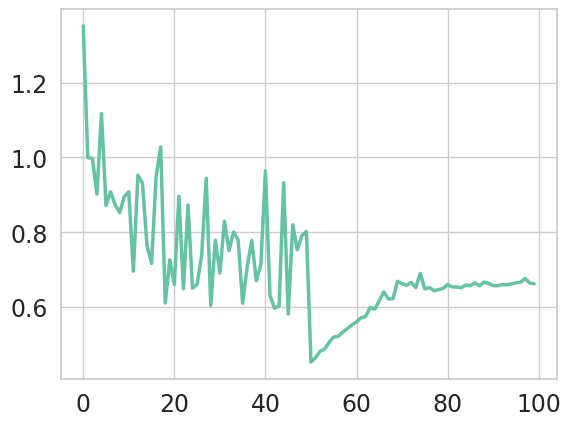

In [42]:
plt.plot(L)

In [49]:
model_name = 'resnet18'
dataset_name = 'CIFAR-10'
regularization = 'l1'
metric = 'test_accuracy'

pivot_table = create_pivot_table(df, model_name, dataset_name, regularization, metric)
print(pivot_table)

Regularization Param  0.0001  0.0005  0.0010  0.0100  0.1000
Bit Width                                                   
bit_32                 70.91   55.46   38.41    10.0    10.0
bit_16                 68.81   42.55   19.97    10.0    10.0
bit_8                  68.52   41.98   19.94    10.0    10.0
bit_4                  59.34   35.00   17.75    10.0    10.0
bit_2                  10.00   10.00   10.00    10.0    10.0


In [58]:
df[["model_name","dataset_name"]]

,model_name,dataset_name
0,lenet,FashionMNIST
1,resnet20,CIFAR-10
2,resnet18,CIFAR-10
3,lenet,MNIST
4,resnet20,CIFAR-10
...,...,...
100,lenet,MNIST
101,lenet,MNIST
102,lenet,FashionMNIST
103,lenet,MNIST


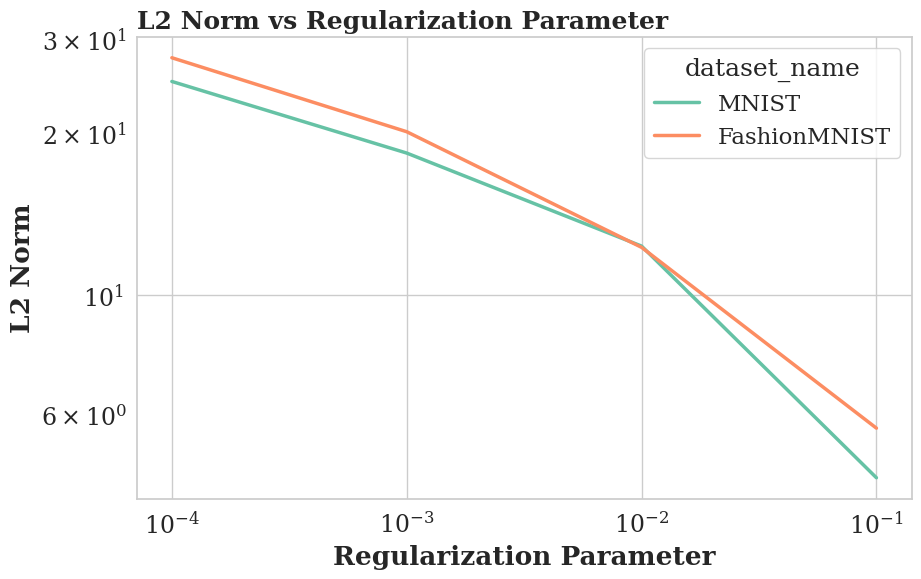

In [14]:
plt.figure(figsize=(10, 6))
plot = sns.lineplot(
    data=filtered_df[filtered_df.regularization == 'l2'],
    x='regularization_param',
    y='l2_norm',
    hue='dataset_name',
)
plot.set_title('L2 Norm vs Regularization Parameter', fontweight='bold', loc='left')
plot.set_xlabel('Regularization Parameter', fontweight='bold')
plot.set_ylabel('L2 Norm', fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.show()

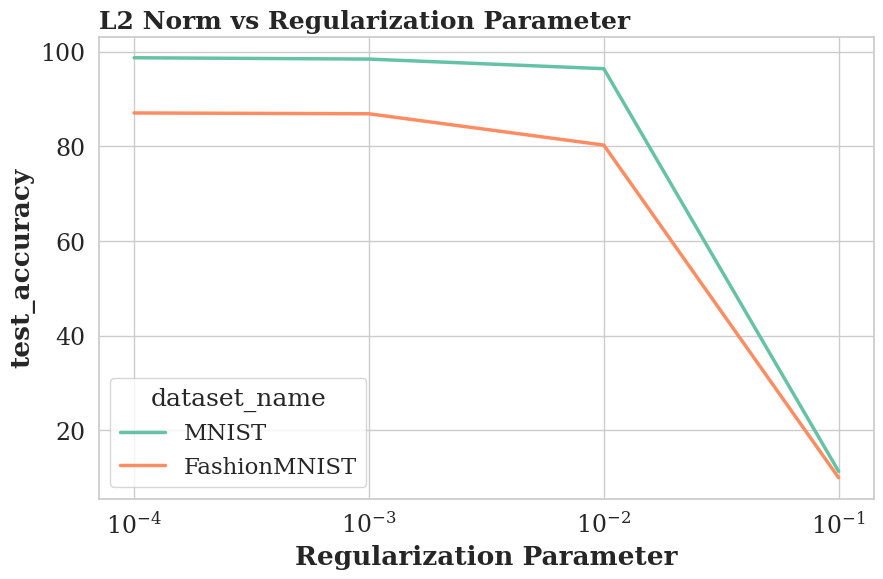

In [23]:
plt.figure(figsize=(10, 6))
plot = sns.lineplot(
    data=filtered_df[filtered_df.regularization == 'l2'],
    x='regularization_param',
    y='test_accuracy',
    hue='dataset_name',
)
plot.set_title('L2 Norm vs Regularization Parameter', fontweight='bold', loc='left')
plot.set_xlabel('Regularization Parameter', fontweight='bold')
plot.set_ylabel('test_accuracy', fontweight='bold')
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [21]:
filtered_df[filtered_df.regularization == 'l2'][['test_accuracy', 'regularization_param']].sort_values('regularization_param')

,test_accuracy,regularization_param
30,98.69,0.0001
47,87.03,0.0001
29,98.41,0.0010
46,86.86,0.0010
28,96.38,0.0100
45,80.25,0.0100
27,11.35,0.1000
44,10.00,0.1000


In [24]:
df

,runner_id,model_name,dataset_name,regularization,regularization_param,train_loss,test_loss,train_accuracy,test_accuracy,timestamp,...,lr,device,batch_size,seed,total_weights,l1_norm,l2_norm,max_weight,min_weight,model_size_mb
0,itaishapira,lenet,MNIST,none,NaN,0.106862,0.093750,96.865000,97.22,2023-11-06_18-24-23,...,0.001,cpu,256,42,128576,6821.780545,44.299252,0.354906,-0.364684,0.490479
1,itaishapira,lenet,MNIST,batch_norm,NaN,0.044411,0.049943,98.648333,98.37,2023-11-06_18-25-02,...,0.001,cpu,256,42,128664,6889.207073,54.414420,1.489537,-0.245150,0.490814
2,itaishapira,lenet,MNIST,layer_norm,NaN,0.041749,0.049787,98.761667,98.34,2023-11-06_18-25-41,...,0.001,cpu,256,42,137536,11533.751559,138.592388,1.195296,-0.412194,0.524658
3,itaishapira,lenet,MNIST,dropout,0.3000,0.111467,0.101370,96.566667,96.68,2023-11-06_18-26-20,...,0.001,cpu,256,42,128576,9273.706537,56.757068,0.371683,-0.404107,0.490479
4,itaishapira,lenet,MNIST,dropout,0.5000,0.156399,0.147546,95.486667,95.56,2023-11-06_18-26-58,...,0.001,cpu,256,42,128576,10089.942562,60.505424,0.319298,-0.370355,0.490479
5,itaishapira,lenet,MNIST,dropout,0.7000,0.509910,0.495203,86.016667,86.82,2023-11-06_18-27-37,...,0.001,cpu,256,42,128576,10357.167816,60.639906,0.356819,-0.338827,0.490479
6,itaishapira,lenet,MNIST,l1,0.1000,6.871712,6.871768,10.441667,10.28,2023-11-06_18-28-16,...,0.001,cpu,256,42,128576,16.458175,0.288702,0.154038,-0.000651,0.490479
7,itaishapira,lenet,MNIST,l1,0.0100,4.405729,4.405073,11.236667,11.35,2023-11-06_18-28-59,...,0.001,cpu,256,42,128576,49.937473,7.331102,0.844597,-0.000659,0.490479
8,itaishapira,lenet,MNIST,l1,0.0010,0.203504,0.184182,93.978333,94.67,2023-11-06_18-29-44,...,0.001,cpu,256,42,128576,433.090295,15.277419,0.416447,-0.389816,0.490479
9,itaishapira,lenet,MNIST,l1,0.0001,0.166344,0.154712,94.961667,95.26,2023-11-06_18-30-27,...,0.001,cpu,256,42,128576,1208.992783,20.065136,0.425115,-0.380133,0.490479
